In [1]:
import numpy as np
import casatools
import casatasks

from scipy.interpolate import interp1d

In [4]:
ms = "QSO-J1429-0104-mod.ms"

In [5]:
tb = casatools.table()
tb.open(ms)
time_array = tb.getcol("TIME")
exposure = np.nanmean(tb.getcol("EXPOSURE"))
tb.close()

ttot = max(time_array) - min(time_array) + exposure

print(ttot, exposure, end="")

626.0 2.0

In [6]:
# calibrate polarisation offset
casatasks.gaincal(
  ms,
  caltable="selfcal-Ginf.tb",
  solint="inf",
  refant="ea19",
  calmode="p",
  solnorm=True,
  solmode="R", 
  gaintype="G", 
  combine="spw",
)

{'apply_tables': array([], dtype='<U5'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
  'field': array([0]),
  'intents': array(['CALIBRATE_AMPLI#UNSPECIFIED', 'CALIBRATE_BANDPASS#UNSPECIFIED',
         'CALIBRATE_FLUX#UNSPECIFIED', 'CALIBRATE_PHASE#UNSPECIFIED',
         'OBSERVE_TARGET#UNSPECIFIED', 'SYSTEM_CONFIGURATION#UNSPECIFIED'],
        dtype='<U32'),
  'observation': array([0]),
  'scan': array([15]),
  'spw': array([0, 1, 2, 3, 4, 5, 6, 7, 8])},
 'solve_tables': array(['selfcal-Ginf.tb'], dtype='<U15'),
 'solvestats': {'above_minblperant': array([1, 1]),
  'above_minsnr': array([1, 1]),
  'data_unflagged': array([1, 1]),
  'expected': array([1, 1]),
  'spw0': {'above_minblperant': array([1, 1]),
   'above_minsnr': array([1, 1]),
   'ant0': {'above_minblperant': array([1, 1]),
    'above_minsnr': array([1, 1]),
    'data_unflagged': array([1, 1]),
    'expected': array(

In [21]:
solint0 = (ttot + 2) / (ttot // 2)

# calibrate polarisation offset
casatasks.gaincal(
  ms,
  caltable="selfcal-Gshort.tb",
  solint=f"{solint0}s",
  refant="ea19", 
  calmode="p", 
  solnorm=True,
  solmode="R", 
  gaintype="G", 
  combine="spw",
  gaintable="selfcal-Ginf.tb",
  spwmap=[0,0,0,0,0,0,0,0,0],
)



Found no unflagged data at:   (time=2019/09/14/21:22:57.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/14/21:23:00.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/14/21:23:47.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2019/09/14/21:23:49.0 field=0 spw=0 chan=0)


{'apply_tables': array(['selfcal-Ginf.tb'], dtype='<U15'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
  'field': array([0]),
  'intents': array(['CALIBRATE_AMPLI#UNSPECIFIED', 'CALIBRATE_BANDPASS#UNSPECIFIED',
         'CALIBRATE_FLUX#UNSPECIFIED', 'CALIBRATE_PHASE#UNSPECIFIED',
         'OBSERVE_TARGET#UNSPECIFIED', 'SYSTEM_CONFIGURATION#UNSPECIFIED'],
        dtype='<U32'),
  'observation': array([0]),
  'scan': array([15]),
  'spw': array([0, 1, 2, 3, 4, 5, 6, 7, 8])},
 'solve_tables': array(['selfcal-Gshort.tb'], dtype='<U17'),
 'solvestats': {'above_minblperant': array([308, 308]),
  'above_minsnr': array([308, 308]),
  'data_unflagged': array([308, 308]),
  'expected': array([312, 312]),
  'spw0': {'above_minblperant': array([308, 308]),
   'above_minsnr': array([308, 308]),
   'ant0': {'above_minblperant': array([308, 308]),
    'above_minsnr': array([308, 308]),
    'da

In [22]:
nsolint = int(ttot // 2)

tb = casatools.table()
tb.open("selfcal-Gshort.tb")
  
ants = tb.getcol("ANTENNA1")
data, flags, time = [], [], []

for ant in np.unique(ants):
    t1 = tb.query(f"ANTENNA1=={ant}")
    data.append(t1.getcol("CPARAM"))
    flags.append(t1.getcol("FLAG"))
    time.append(t1.getcol("TIME"))     
    t1.close() 

data = np.ma.array(data, mask=flags)[:, :, 0].T 
time = np.mean(time, axis=0)

tb.close()

True

In [23]:
print(data.shape)

(308, 2, 27)


In [28]:
dt_list = []
varI_list, varN_list = [], []
var0 = np.nanvar((data[:, 0] - data[:, 1]) / np.sqrt(2))

nsolint = int(ttot // 2)

for nt in range(1, data.shape[0]):
    dt_list.append(data.shape[0] // nt)

dt_list = np.unique(dt_list)[:-1]

for n, dt in enumerate(dt_list):
    data_nt, time_nt = [], []
    nt = data.shape[0] // dt

    for i in range(nt):
        data_nt.append(np.nanmean(data[i*dt:(i+1)*dt], axis=0))
        time_nt.append(np.nanmean(time[i*dt:(i+1)*dt], axis=0))

    data_nt = interp1d(time_nt, data_nt, fill_value="extrapolate", axis=0)(time)[:, [1, 0]]
    varI_list.append(np.nanvar(data - data_nt) - var0 * (1 + nt / nsolint / dt))
    varN_list.append(var0 * nt / nsolint / dt)

    print(solint0, ttot, nsolint, var0, nt, data.shape[0], dt)

0 1
2.0063897763578273 626.0 313 0.0003620326476738756 308 308 1
1 2
2.0063897763578273 626.0 313 0.0003620326476738756 154 308 2
2 3
2.0063897763578273 626.0 313 0.0003620326476738756 102 308 3
3 4
2.0063897763578273 626.0 313 0.0003620326476738756 77 308 4
4 5
2.0063897763578273 626.0 313 0.0003620326476738756 61 308 5
5 6
2.0063897763578273 626.0 313 0.0003620326476738756 51 308 6
6 7
2.0063897763578273 626.0 313 0.0003620326476738756 44 308 7
7 8
2.0063897763578273 626.0 313 0.0003620326476738756 38 308 8
8 9
2.0063897763578273 626.0 313 0.0003620326476738756 34 308 9
9 10
2.0063897763578273 626.0 313 0.0003620326476738756 30 308 10
10 11
2.0063897763578273 626.0 313 0.0003620326476738756 28 308 11
11 12
2.0063897763578273 626.0 313 0.0003620326476738756 25 308 12
12 13
2.0063897763578273 626.0 313 0.0003620326476738756 23 308 13
13 14
2.0063897763578273 626.0 313 0.0003620326476738756 22 308 14
14 15
2.0063897763578273 626.0 313 0.0003620326476738756 20 308 15
15 16
2.006389776357

In [ ]:
print(dt_list)
print(data.shape)

[ 1  2  3  4  5  6  7 10 15]
(31, 2, 27)


In [53]:
varI_list = np.array(varI_list)
varN_list = np.array(varN_list)
var_tot = varI_list + 18 * varN_list
imin = np.nanargmin(var_tot)
solint = solint0 * np.array(dt_list)[imin]

print(1 / np.sqrt(var_tot[imin]))
print(2 * 0.15 * np.sqrt(var_tot[imin]) / 0.00006)
print(solint)

65.90706180619387
75.86440455657069
18.057507987220447


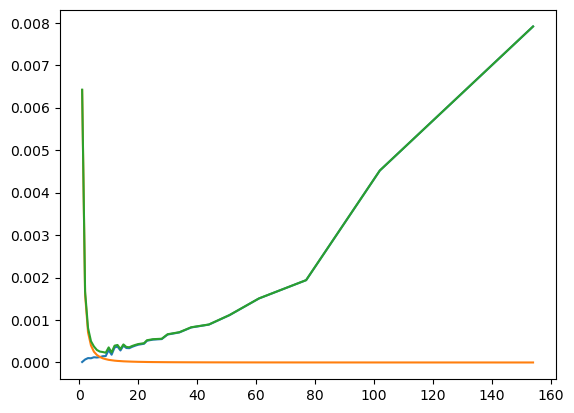

In [30]:
import matplotlib.pyplot as plt

plt.plot(dt_list, varI_list)
plt.plot(dt_list, 18 * varN_list)
plt.plot(dt_list, varI_list + 18 * varN_list)